In [78]:
import os
os.getcwd()

'C:\\Users\\lorenz.hering\\Desktop\\BE\\02_Schulungen\\Data Analyst Nanodegree\\05 Open Street Map'

In [79]:
os.listdir()

['.ipynb_checkpoints',
 'Back Up',
 'clean_sd.osm',
 'mydb.db',
 'nodes.csv',
 'nodes_tags.csv',
 'Open Street Map Project.ipynb',
 'schema.py',
 'sd.db',
 'sd.osm',
 'ways.csv',
 'ways_nodes.csv',
 'ways_tags.csv',
 '__pycache__']

# Open Street Map Project

## Intro
OpenStreetMap (OSM) is an open-source project attempting to create a free map of the world (think Google Maps).
The data is gathered and entered voluntarilly. It is maintained by the OpenStreetMap foundation and is a colloborative effort with > 2 million contributors. OpenStreetMap data is freely available to download in many formats.


OSM presents an ideal opportunity to practice data wrangling since:

- The data is user-generated meaning there will be a significant quantity of errors/ not stringent data
- The datas is free to download in many formats including XML
- The data are relatable and human-understandable because they represent real places

I decided to work with the area of San Diego because I spend a semester abroad there. Specifically, I lived in the Pacific Beach area. I thought it would be nice to explore the city through the datas after many hours spent experiencing the city in the real world.

## Data Audit

The first step was to download the map as an XML file. Looking at the XML file, we see that it uses different types of tags. I did this parsing my dataset and using ElementTree and then count the number of unique tags.

There are three core, top-level elements in OSM:

- Nodes represent a single point and have an id, latitude, and longitude.

- Ways are made up of ordered lists of nodes that describe a linear feature such as a trail, or an area such as a park. They contain a list of the nodes that comprise the way as well as tags for detailed information.

- Relations are comprised of an ordered list of members that can be either nodes or ways. They are used to represent logically or geographic relationships between features and contain a list of members as well as tags describing the element.

In [80]:
# exploring data (xml file) with regard to tag types using iterparse to count the number of tags
# data source: https://www.openstreetmap.org/export#map=11/32.7483/-116.9810

import xml.etree.cElementTree as ET
from collections import defaultdict
import pprint
import re


def count_tags(filename):
    tags={}
    
    for event, elem in ET.iterparse(filename):
       if elem.tag not in tags.keys():
           tags[elem.tag]=1
       else:
         
           tags[elem.tag] +=1
    return tags
tags=count_tags("sd.osm")
pprint.pprint(tags)

{'bounds': 1,
 'member': 24956,
 'meta': 1,
 'nd': 947068,
 'node': 1057269,
 'note': 1,
 'osm': 1,
 'relation': 1921,
 'tag': 2243609,
 'way': 117888}


### Explore patterns in the tags

The "k" value of each tag contains various patterns. Using the 3 regular expressions, we can check for certain patterns in the tags. Here, I counted the frequency of each of the tag categories:

- 'lower': 611,373, for tags with only valid lowercase letters
- 'lower_colon': 1,597,473, for tags with a colon in their names
- 'problemchars': 3, tags with problematic characters
- 'other': 34,760, for other tags

In [81]:
# check the "k" value for each "<tag>" and see if there are any potential problems.
# We have provided you with 3 regular expressions to check for certain patterns in the tags. As we saw in the quiz earlier, we would like to change the data
# model and expand the "addr:street" type of keys to a dictionary like this:{"address": {"street": "Some value"}}
# So, we have to see if we have such tags, and if we have any tags with problematic characters.

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys):
    if element.tag == "tag":
        if (lower.search(element.attrib['k'])!=None):
            keys['lower']+=1
        elif lower_colon.search(element.attrib['k'])!=None:
            keys['lower_colon']+=1
        elif problemchars.search(element.attrib['k'])!=None:
            keys['problemchars']+=1
        else :
            keys['other']+=1
        
    return keys


def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys


keys=process_map("sd.osm")
pprint.pprint(keys)

{'lower': 611373, 'lower_colon': 1597473, 'other': 34760, 'problemchars': 3}


In [86]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint

OSMFILE = "sd.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons", "Broadway", "Way"]

mapping = { "St": "Street",
            "St.": "Street",
            "Ave": "Avenue",
            "Av": "Avenue",
            "Ave.": "Avenue",
            "Rd.": "Road",
            "Rd": "Road",
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "Bl": "Boulevard",
            "Dr": "Drive",
            "Dr.": "Drive",
            "Wy": "Way"
            }

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    osm_file = open(osmfile, "r", encoding='utf-8')
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    
    return street_types

#pprint.pprint(dict(audit(OSMFILE)))


## Data Cleaning

For the data cleaning, I decided on the following approach, adapted from the Udacity course on Data Wrangling:

1. Identify the causes of any inconsistent/incorrect data
2. Develop a set of corrective cleaning actions
3. Implement the data cleaning plan: run cleaning scripts and transfer the cleaned data to .csv files
4. Import the data from .csv files to a SQL database and perform SQL queries on the data to identify any further inconsistencies that would necessitate returning to step 1.

Data wrangling is an iterative procedure, and as such, I expected that I might need to work through these steps several times. 


### Street Types

The primary variable I could audit for validity and consistency was the street names associated with the node and way tag. 
The main problem here is that there are a lot of inconsistencies in the street names. From my initial exploratory examination of the data, I had noticed a wide variety in street name endings and abbreviations.

Using a provisional street name auditing script, I compared the street endings to a standardized list and counted the number of times each non-standard type appeared using the following function:

In order to standardize the street names, I created a mapping and applied it to the data during the conversion from XML to CSV files.


In [83]:
def update_name(name, mapping):
    name = name.replace(",", "")
    for word in name.split(" "):
        if word in mapping.keys():
            name = name.replace(word, mapping[word])

    return name


st_types = audit(OSMFILE)
pprint.pprint(dict(st_types))

for st_type, ways in st_types.items():
    for name in ways:
        better_name = update_name(name, mapping)
        print(name, "=>", better_name)

{'101': {'Murphy Canyon Road #101'},
 '103': {'Mission Boulevard #103'},
 '1500': {'B Street Suite 1500'},
 '18': {'Clairemont Mesa Blvd #18'},
 '3604': {'Admiral Baker Rd #3604'},
 '75': {'Highway 75'},
 '92131': {'92131'},
 'A': {'Delaware Saint A'},
 'Abajo': {'Calle Abajo'},
 'Abeto': {'Caminito Abeto'},
 'Abrazo': {'Caminito Abrazo'},
 'Acapulco': {'Camino Playa Acapulco'},
 'Acento': {'Caminito Acento'},
 'Acero': {'Avenida Acero'},
 'Acuario': {'Corte Acuario', 'Senda Acuario'},
 'Adriane': {'Rue Adriane'},
 'Afable': {'Via Afable'},
 'Afuera': {'Caminito Afuera'},
 'Agadir': {'Caminito Agadir'},
 'Agrado': {'Caminito Agrado'},
 'Aguadulce': {'Calle Aguadulce'},
 'Alamar': {'Avenida Alamar'},
 'Alcazar': {'Via Alcazar'},
 'Alegre': {'Caminito Alegre'},
 'Alessandro': {'Via Alessandro'},
 'Aleta': {'Camino Aleta'},
 'Alianza': {'Calle de la Alianza'},
 'Alicante': {'Via Alicante'},
 'Alicia': {'Caminito Alicia'},
 'Aliviado': {'Caminito Aliviado'},
 'Allazon': {'Via del Allazon'}

         'Deerford Row',
         'Encino Row',
         'Falkirk Row',
         'Firwood Row',
         'Flagstone Row',
         'Glennchester Row',
         'Greenhedge Row',
         'Hedgewood Row',
         'Heritage Park Row',
         'Hillpointe Row',
         'Keeneland Row',
         'Meadowpointe Row',
         'Merryfield Row',
         'Oakgate Row',
         'Panamint Row',
         'Park Row',
         'Regents Park Row',
         'Ridgegate Row',
         'River Glen Row',
         'River Vista Row',
         'Selkirk Row',
         'Shaw Lopez Row',
         'Talmadge Canyon Row',
         'Talmadge Park Row',
         'Visalia Row',
         'Wooddale Row'},
 'Rufo': {'Vista San Rufo'},
 'Ruiz': {'Camino Ruiz'},
 'Saba': {'Via San Saba'},
 'Sabato': {'Paseo de Sabato'},
 'Sacate': {'Caminito Sacate'},
 'Salado': {'Caminito Salado'},
 'Sana': {'Caminito Sana'},
 'Sanchez': {'Avenida Sanchez'},
 'Sano': {'Corte Sano'},
 'Santiago': {'Calle Santiago'},
 'Santos': {'Via 

Caminito Cassis => Caminito Cassis
Camino Calabazo => Camino Calabazo
Hartzel Crest => Hartzel Crest
Caminito Aronimink => Caminito Aronimink
Plaza Cuernavaca => Plaza Cuernavaca
Calle Tortuosa => Calle Tortuosa
Via Trieste => Via Trieste
Via Curvada => Via Curvada
Via Tabara => Via Tabara
Corte Mar Asombrosa => Corte Mar Asombrosa
Via Promesa => Via Promesa
Calle del Cielo => Calle del Cielo
Caminito Manresa => Caminito Manresa
Caminito Zopilote => Caminito Zopilote
Via la Paloma => Via la Paloma
Fern Glen => Fern Glen
Callejon Cervantes => Callejon Cervantes
Porte de Palmas => Porte de Palmas
Via Las Palmas => Via Las Palmas
Camino de Las Palmas => Camino de Las Palmas
Via del Tanido => Via del Tanido
Caminito Jovial => Caminito Jovial
Caminito Fuente => Caminito Fuente
Callejon Ciudad => Callejon Ciudad
Calle Sal Si Puedes => Calle Sal Si Puedes
Caminito Ascua => Caminito Ascua
Caminito Barlovento => Caminito Barlovento
Via Excelencia => Via Excelencia
Caminito Garcia => Caminito Ga

In [84]:
#import csv
import unicodecsv as csv
import codecs
import re
import xml.etree.cElementTree as ET
from unittest import TestCase


import json
import cerberus
import schema

OSM_PATH = "sd.osm"

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema.schema

NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  

    if element.tag == 'node':
        for attrib in element.attrib:
            if attrib in NODE_FIELDS:
                node_attribs[attrib] = element.attrib[attrib]
        
        for child in element:
            node_tag = {}
            if LOWER_COLON.match(child.attrib['k']):
                node_tag['type'] = child.attrib['k'].split(':',1)[0]
                node_tag['key'] = child.attrib['k'].split(':',1)[1]
                node_tag['id'] = element.attrib['id']
                node_tag['value'] = child.attrib['v']
                tags.append(node_tag)
            elif PROBLEMCHARS.match(child.attrib['k']):
                continue
            else:
                node_tag['type'] = 'regular'
                node_tag['key'] = child.attrib['k']
                node_tag['id'] = element.attrib['id']
                node_tag['value'] = child.attrib['v']
                tags.append(node_tag)
        
        return {'node': node_attribs, 'node_tags': tags}
        
    elif element.tag == 'way':
        for attrib in element.attrib:
            if attrib in WAY_FIELDS:
                way_attribs[attrib] = element.attrib[attrib]
        
        position = 0
        for child in element:
            way_tag = {}
            way_node = {}
            
            if child.tag == 'tag':
                if LOWER_COLON.match(child.attrib['k']):
                    way_tag['type'] = child.attrib['k'].split(':',1)[0]
                    way_tag['key'] = child.attrib['k'].split(':',1)[1]
                    way_tag['id'] = element.attrib['id']
                    way_tag['value'] = child.attrib['v']
                    tags.append(way_tag)
                elif PROBLEMCHARS.match(child.attrib['k']):
                    continue
                else:
                    way_tag['type'] = 'regular'
                    way_tag['key'] = child.attrib['k']
                    way_tag['id'] = element.attrib['id']
                    way_tag['value'] = child.attrib['v']
                    tags.append(way_tag)
                    
            elif child.tag == 'nd':
                way_node['id'] = element.attrib['id']
                way_node['node_id'] = child.attrib['ref']
                way_node['position'] = position
                position += 1
                way_nodes.append(way_node)
        
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.items())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_strings = (
            "{0}: {1}".format(k, v if isinstance(v, str) else ", ".join(v))
            for k, v in errors.items()
        )
        raise cerberus.ValidationError(
            message_string.format(field, "\n".join(error_strings))
        )


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, str) else v) for k, v in row.items()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'wb') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'wb') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'wb') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'wb') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'wb') as way_tags_file:

        nodes_writer = csv.DictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = csv.DictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = csv.DictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = csv.DictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = csv.DictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    process_map(OSM_PATH, validate=True)

### SQL Database

When the San Diego OSM data was converted from the original source XML file to 5 different CSV files the first data cleaning precudure was conducted. In the conversion process, the data was validated against a predefined schema.py file to ensure that both the structure of the csv files and the types of the data entered were as expected (according to the defined schema).

This procedure took me some time and was finally susccessfully completed after several tries and some researching and posting on stackoverflow etc.. Plus reworking of the cleaning and converting scripts. The main problem was that I am using Python 3 and the Lesson sample code is written for Python 2.

The next step was to initialize a SQL database and to create the tables within based on a pre-defined schema.

In [2]:
import sqlite3
import csv
from pprint import pprint

sqlite_file = 'sandiego.db'    # name of the sqlite database file

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Get a cursor object
cur = conn.cursor()

# Create the nodes table, specifying the column names and data types:
cur.execute('''
    CREATE TABLE IF NOT EXISTS nodes (id INTEGER PRIMARY KEY, lat REAL, 
    lon REAL, user TEXT, uid INTEGER, version TEXT, changeset INTEGER, timestamp DATE)
''')
conn.commit()

# Read in the csv file as a dictionary, format the
# data as a list of tuples:
with open('nodes.csv','rt', encoding="utf8") as fin:
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db = [(i['id'], i['lat'],i['lon'],i['user'],
              i['uid'],i['version'],i['changeset'],i['timestamp']) for i in dr]


# insert the formatted data
cur.executemany("INSERT OR IGNORE INTO nodes(id, lat, lon, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?,?, ?, ?, ?);", to_db)
conn.commit()

In [183]:
# test
import sqlite3
import csv
from pprint import pprint

sqlite_file = 'sandiego.db'    # name of the sqlite database file

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Get a cursor object
cur = conn.cursor()

cur.execute("SELECT value FROM ways_tags")
all_rows = cur.fetchall()
print('1):')
pprint(all_rows)

conn.close()

1):
[('coastline',),
 ('PGS',),
 ('coastline',),
 ('clean',),
 ('decliner imported from PGS. All original nodes moved/removed',),
 ('PGS',),
 ('coastline',),
 ('PGS',),
 ('coastline',),
 ('clean',),
 ('decliner imported from PGS. All original nodes moved/removed',),
 ('PGS',),
 ('coastline',),
 ('clean',),
 ('decliner imported from PGS. All original nodes moved/removed',),
 ('PGS',),
 ('coastline',),
 ('PGS',),
 ('coastline',),
 ('PGS',),
 ('coastline',),
 ('PGS',),
 ('coastline',),
 ('clean',),
 ('decliner imported from PGS. All original nodes moved/removed',),
 ('PGS',),
 ('coastline',),
 ('PGS',),
 ('coastline',),
 ('PGS',),
 ('coastline',),
 ('PGS',),
 ('coastline',),
 ('PGS',),
 ('coastline',),
 ('clean',),
 ('decliner imported from PGS. All original nodes moved/removed',),
 ('PGS',),
 ('coastline',),
 ('PGS',),
 ('coastline',),
 ('PGS',),
 ('residential',),
 ('Esplendente Boulevard',),
 ('A41',),
 ('San Diego, CA',),
 ('Esplendente',),
 ('Blvd',),
 ('no',),
 ('residential',),
 ('

 ('tiger_import_dch_v0.6_20070809',),
 ('195704890',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195703868',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('residential',),
 ('A41',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195320835:195320843:195320846:195320847',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195710890:195710893:195710894',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tig

 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('Miramar Road; Pomerado Road',),
 ('motorway_link',),
 ('4',),
 ('yes',),
 ('A63',),
 ('San Diego, CA',),
 ('left|left|right|right',),
 ('no',),
 ('I 805 North',),
 ('motorway_link',),
 ('yes',),
 ('A63',),
 ('San Diego, CA',),
 ('primary_link',),
 ('45 mph',),
 ('yes',),
 ('sign',),
 ('A63',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('I 5 North',),
 ('Tocayo Avenue',),
 ('motorway_link',),
 ('yes',),
 ('A63',),
 ('San Diego, CA',),
 ('no',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195755805',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('no',),
 ('I 8 East; Rosecrans Street',),
 ('El Centro;Rosecrans Street South',),
 ('El Centro|Rosecrans Street South',),
 ('I 8 East',),
 ('I 8 East|',),
 ('motorway_link',),
 ('2',),
 ('yes',),
 ('no',),
 ('Martin Luthar King Junior Freeway',),
 ('CA 94 West',),
 ('motorway_link',),
 ('yes',),
 ('A63',),
 ('San Diego

 ('no',),
 ('track',),
 ('A51',),
 ('San Diego, CA',),
 ('pedestrian',),
 ('A51',),
 ('San Diego, CA',),
 ('pedestrian',),
 ('A51',),
 ('San Diego, CA',),
 ('no',),
 ('Junction',),
 ('CA 15 North',),
 ('motorway_link',),
 ('2',),
 ('yes',),
 ('A63',),
 ('San Diego, CA',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195723841',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('residential',),
 ('A41',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195702261',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('residential',),
 ('A41',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195702264',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('residential',),
 ('A41',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),


 ('4',),
 ('65 mph',),
 ('Escondido Freeway',),
 ('yes',),
 ('I 15',),
 ('A15',),
 ('San Diego, CA',),
 ('I-15',),
 ('Escondido',),
 ('Fwy',),
 ('residential',),
 ('A41',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195702493',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('service',),
 ('alley',),
 ('A71',),
 ('San Diego, CA',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195769361:195769362',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('service',),
 ('alley',),
 ('A71',),
 ('San Diego, CA',),
 ('private',),
 ('Potlatch 0.10f',),
 ('residential',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195738861:195685524:195685527:195685468',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('Palomar Street',),
 ('motorway_link',),
 ('yes',),
 ('A63',),
 ('San Diego, CA',),
 ('no',),
 ('priva

 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('Potlatch 0.10b',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195734928',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195706681',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195717724:195717725',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195717727:195717728',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195717729',),
 ('bulk_upload.pl-5dac241b-d

 ('San Diego, CA',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('I 15 North',),
 ('I 805 North',),
 ('motorway_link',),
 ('2C',),
 ('1',),
 ('yes',),
 ('A63',),
 ('San Diego, CA',),
 ('residential',),
 ('Froude Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Froude',),
 ('St',),
 ('no',),
 ('no',),
 ('designated',),
 ('yes',),
 ('motorway',),
 ('2',),
 ('65 mph',),
 ('Escondido Freeway',),
 ('yes',),
 ('CA 15',),
 ('Title 23: Highways Part 658 '
  'http://ecfr.gpoaccess.gov/cgi/t/text/text-idx?c=ecfr&rgn=div5&view=text&node=23:1.0.1.7.33&idno=23',),
 ('sign',),
 ('A15:A41',),
 ('San Diego, CA',),
 ('I-15',),
 ('Escondido',),
 ('Fwy',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195704544',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('residential',),
 ('A41',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195319264',),
 ('bu

 ('A64',),
 ('San Diego, CA',),
 ('residential',),
 ('A41',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195714126',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('residential',),
 ('A41',),
 ('San Diego, CA',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195714129',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195717676',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195717678',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),
 ('San Diego, CA',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195717679',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('private',),
 ('service',),
 ('A74',),

 ('San Diego, CA',),
 ('Varona',),
 ('St',),
 ('no',),
 ('residential',),
 ('Perez Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Perez',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Tourmaline Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Tourmaline',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Camino Catalonia',),
 ('A41',),
 ('San Diego, CA',),
 ('Camino Catalonia',),
 ('no',),
 ('unclassified',),
 ('roundabout',),
 ('yes',),
 ('San Diego, CA',),
 ('residential',),
 ('Leighton Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Leighton',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Leighton Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Leighton',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Ridgegate Row',),
 ('A41',),
 ('San Diego, CA',),
 ('Ridgegate',),
 ('Row',),
 ('no',),
 ('residential',),
 ('Dalbergia Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Dalbergia',),
 ('Ct',),
 ('no',),
 ('footway',),
 ('Kennebeck Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Kennebeck',),
 ('Ct',),
 ('no',),
 ('r

 ('Buena Vista Way',),
 ('A41',),
 ('San Diego, CA',),
 ('Buena Vista',),
 ('Way',),
 ('no',),
 ('Chula Vista',),
 ('91910',),
 ('CA',),
 ('Buena Vista Way',),
 ('residential',),
 ('Buena Vista Way',),
 ('A41',),
 ('San Diego, CA',),
 ('Buena Vista',),
 ('Way',),
 ('no',),
 ('residential',),
 ('Sweetwater Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Sweetwater',),
 ('Ln',),
 ('no',),
 ('residential',),
 ('Sweetwater Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Sweetwater',),
 ('Ln',),
 ('no',),
 ('residential',),
 ('Sweetwater Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Sweetwater',),
 ('Ln',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195655480',),
 ('residential',),
 ('Dillard Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Dillard',),
 ('St',),
 ('no',),
 ('tertiary',),
 ('South Meadowbrook Drive',),
 ('both',),
 ('A41',),
 ('San Diego, CA',),
 ('Meadowbrook',),
 ('S',),
 ('Dr',),
 ('no',),
 ('residential',),
 ('Thanksgiving Lane',),
 ('A41',),
 ('San Diego, CA',),
 (

 ('Dr',),
 ('no',),
 ('residential',),
 ('Revena Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Revena',),
 ('St',),
 ('no',),
 ('residential',),
 ('Yellowtail Way',),
 ('A41',),
 ('San Diego, CA',),
 ('Yellowtail',),
 ('Way',),
 ('no',),
 ('residential',),
 ('Lawn View Drive',),
 ('A41',),
 ('San Diego, CA',),
 ('Lawnview',),
 ('Dr',),
 ('no',),
 ('residential',),
 ('Crossland Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Crossland',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Sinclair Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Sinclair',),
 ('Ln',),
 ('no',),
 ('residential',),
 ('Alder Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Alder',),
 ('St',),
 ('no',),
 ('yes',),
 ('residential',),
 ('North Mission Bay Drive',),
 ('A41',),
 ('San Diego, CA',),
 ('Mission Bay',),
 ('N',),
 ('Dr',),
 ('no',),
 ('unclassified',),
 ('North Mission Bay Drive',),
 ('A41',),
 ('San Diego, CA',),
 ('Mission Bay',),
 ('N',),
 ('Dr',),
 ('no',),
 ('residential',),
 ('Chauncey Drive',),
 ('A41',),
 ('Sa

 ('San Diego, CA',),
 ('Greenbrier',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Seacrest View Road',),
 ('A41',),
 ('San Diego, CA',),
 ('Seacrest View',),
 ('Rd',),
 ('no',),
 ('residential',),
 ('Williamsburg Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Williamsburg',),
 ('Ln',),
 ('no',),
 ('residential',),
 ('Williamsburg Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Williamsburg',),
 ('Ln',),
 ('no',),
 ('residential',),
 ("Rue d' Orleans",),
 ('A41',),
 ('San Diego, CA',),
 ("Rue d' Orleans",),
 ('no',),
 ('residential',),
 ('Carol Way',),
 ('A41',),
 ('San Diego, CA',),
 ('Carol',),
 ('Way',),
 ('no',),
 ('residential',),
 ('Somam Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('Somam',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('Somam Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('Somam',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('Lyle Drive',),
 ('A41',),
 ('San Diego, CA',),
 ('Lyle',),
 ('Dr',),
 ('residential',),
 ('Kiwi Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Kiwi',),
 

 ('Ct',),
 ('no',),
 ('residential',),
 ('Whiteport Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Whiteport',),
 ('Ln',),
 ('no',),
 ('residential',),
 ('Keoki Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Keoki',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Lilac Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('Lilac',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('Lilac Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('Lilac',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('Monet Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Monet',),
 ('Ln',),
 ('no',),
 ('residential',),
 ('Amarillo Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('Amarillo',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('Palomar Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('Palomar',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('Corliss Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Corliss',),
 ('St',),
 ('residential',),
 ('Caminito el Rosario',),
 ('A41',),
 ('San Diego, CA',),
 ('Caminito el Rosario',),
 ('no',),
 ('residential',),
 ('

 ('A41',),
 ('San Diego, CA',),
 ('Manhattan',),
 ('Ct',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195299859',),
 ('bulk_upload.pl-5dac241b-d144-4c9c-9e26-b4dec4590a61',),
 ('residential',),
 ('Drew View Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Drew View',),
 ('Ln',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195704922:195704926',),
 ('residential',),
 ('Pavlov Avenue',),
 ('both',),
 ('A41',),
 ('San Diego, CA',),
 ('Pavlov',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('Carlow Way',),
 ('A41',),
 ('San Diego, CA',),
 ('Carlow',),
 ('Way',),
 ('no',),
 ('residential',),
 ('Petit Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Petit',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Nagel Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Nagel',),
 ('St',),
 ('no',),
 ('footway',),
 ('Liverpool Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Liverpool',),
 ('Ct',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195299878',),
 ('bulk_upload.pl-5d

 ('Ave',),
 ('no',),
 ('residential',),
 ('G Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('G',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('G Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('G',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('G Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('G',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('G Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('G',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('G Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('G',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('G Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('G',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('G Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('G',),
 ('Ave',),
 ('no',),
 ('tertiary',),
 ('Colina Dorada Drive',),
 ('A41',),
 ('San Diego, CA',),
 ('Colina Dorada',),
 ('Dr',),
 ('no',),
 ('residential',),
 ('Janan Way',),
 ('both',),
 ('A41',),
 ('San Diego, CA',),
 ('Janan',),
 ('Way',),
 ('no',),
 ('residential',),
 ('2',),
 ('Larga Court',),
 ('asphalt',),
 ('A41',

 ('East Olive Drive',),
 ('A41',),
 ('San Diego, CA',),
 ('Olive',),
 ('Dr',),
 ('no',),
 ('designated',),
 ('residential',),
 ('Tower Road',),
 ('A41',),
 ('San Diego, CA',),
 ('Tower',),
 ('Rd',),
 ('residential',),
 ('Tower Road',),
 ('A41',),
 ('San Diego, CA',),
 ('Tower',),
 ('Rd',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195683699:195683700',),
 ('residential',),
 ('Gayuba Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Gayuba',),
 ('Ln',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195719795',),
 ('residential',),
 ('Savoy Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Savoy',),
 ('St',),
 ('residential',),
 ('Savoy Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Savoy',),
 ('St',),
 ('residential',),
 ('Black Oak Road',),
 ('A41',),
 ('San Diego, CA',),
 ('Black Oak',),
 ('Rd',),
 ('no',),
 ('residential',),
 ('Hilltop Drive',),
 ('A41',),
 ('San Diego, CA',),
 ('Hilltop',),
 ('Dr',),
 ('no',),
 ('residential',),
 ('Hilltop Drive',),
 ('A41',),

 ('residential',),
 ('Plaza Anita',),
 ('A41',),
 ('San Diego, CA',),
 ('Plaza Anita',),
 ('no',),
 ('residential',),
 ('Lake Mere Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Lake Mere',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Elder Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Elder',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Organdy Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Organdy',),
 ('Ln',),
 ('residential',),
 ('Mount Ainsworth Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('Mount Ainsworth',),
 ('Ave',),
 ('residential',),
 ('Vigo Drive',),
 ('A41',),
 ('San Diego, CA',),
 ('Vigo',),
 ('Dr',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195707057:195707065:195707066',),
 ('residential',),
 ('Pacific Haven Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Pacific Haven',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Embassy Way',),
 ('A41',),
 ('San Diego, CA',),
 ('Embassy',),
 ('Way',),
 ('no',),
 ('residential',),
 ('Belle Haven Drive',),
 ('A41',),
 ('San Die

 ('Couts',),
 ('St',),
 ('residential',),
 ('Couts Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Couts',),
 ('St',),
 ('secondary',),
 ('yes',),
 ('Catalina Boulevard',),
 ('icommutesd.com',),
 ('A41',),
 ('San Diego, CA',),
 ('Catalina',),
 ('Blvd',),
 ('residential',),
 ('Catalina Boulevard',),
 ('A41',),
 ('San Diego, CA',),
 ('Catalina',),
 ('Blvd',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195710755:195710759:195752520:195753152:195753955',),
 ('secondary',),
 ('Catalina Boulevard',),
 ('asphalt',),
 ('A41',),
 ('San Diego, CA',),
 ('Catalina',),
 ('Blvd',),
 ('private',),
 ('residential',),
 ('Caminito Baywood',),
 ('A41',),
 ('San Diego, CA',),
 ('Caminito Baywood',),
 ('no',),
 ('residential',),
 ('Admiral Baker Road',),
 ('A41',),
 ('San Diego, CA',),
 ('Admiral Baker',),
 ('Rd',),
 ('no',),
 ('residential',),
 ('Admiral Baker Road',),
 ('A41',),
 ('San Diego, CA',),
 ('Admiral Baker',),
 ('Rd',),
 ('no',),
 ('91950',),
 ('tertiary',),
 ('San Diego, CA',),
 ('Mile o

 ('Dr',),
 ('no',),
 ('residential',),
 ('Starlight Drive',),
 ('A41',),
 ('San Diego, CA',),
 ('Starlight',),
 ('Dr',),
 ('no',),
 ('residential',),
 ('Verus Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Verus',),
 ('St',),
 ('no',),
 ('residential',),
 ('Fez Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Fez',),
 ('St',),
 ('no',),
 ('residential',),
 ('Caminito Barlovento',),
 ('A41',),
 ('San Diego, CA',),
 ('Caminito Barlovento',),
 ('no',),
 ('residential',),
 ('Uvas Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Uvas',),
 ('St',),
 ('no',),
 ('residential',),
 ('Sampson Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Sampson',),
 ('St',),
 ('residential',),
 ('Nickman Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Nickman',),
 ('St',),
 ('no',),
 ('residential',),
 ('Rivera Place',),
 ('A41',),
 ('San Diego, CA',),
 ('Rivera',),
 ('Pl',),
 ('no',),
 ('residential',),
 ('Thelborn Way',),
 ('A41',),
 ('San Diego, CA',),
 ('Thelborn',),
 ('Way',),
 ('no',),
 ('residential',),
 ('Ardilla

 ('San Diego, CA',),
 ('Calumet',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('Plaza del Cid',),
 ('A41',),
 ('San Diego, CA',),
 ('Plaza del Cid',),
 ('no',),
 ('residential',),
 ('Marquette Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Marquette',),
 ('St',),
 ('no',),
 ('residential',),
 ('Reagan Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Reagan',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Del Paso Place',),
 ('A41',),
 ('San Diego, CA',),
 ('Del Paso',),
 ('Pl',),
 ('no',),
 ('residential',),
 ('Lynn Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Lynn',),
 ('St',),
 ('no',),
 ('residential',),
 ('South Bancroft Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Bancroft',),
 ('S',),
 ('St',),
 ('residential',),
 ('South Bancroft Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Bancroft',),
 ('S',),
 ('St',),
 ('residential',),
 ('South Bancroft Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Bancroft',),
 ('S',),
 ('St',),
 ('residential',),
 ('2',),
 ('Caminito Salado',),
 ('A41',),
 ('Sa

 ('Quince',),
 ('St',),
 ('residential',),
 ('Quince Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Quince',),
 ('St',),
 ('residential',),
 ('Quince Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Quince',),
 ('St',),
 ('residential',),
 ('Quince Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Quince',),
 ('St',),
 ('residential',),
 ('Quince Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Quince',),
 ('St',),
 ('residential',),
 ('Quince Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Quince',),
 ('St',),
 ('no',),
 ('residential',),
 ('Quince Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Quince',),
 ('St',),
 ('residential',),
 ('Quince Street',),
 ('A41',),
 ('San Diego, CA',),
 ('Quince',),
 ('St',),
 ('no',),
 ('residential',),
 ('Delta Park Lane',),
 ('A41',),
 ('San Diego, CA',),
 ('Delta Park',),
 ('Ln',),
 ('no',),
 ('residential',),
 ('Melrose Circle',),
 ('A41',),
 ('San Diego, CA',),
 ('Melrose',),
 ('Cir',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195654546',)

 ('Rain Forest Rd',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195364015',),
 ('residential',),
 ('Emerald Lake Avenue',),
 ('A41',),
 ('San Diego, CA',),
 ('Emerald Lake',),
 ('Ave',),
 ('no',),
 ('residential',),
 ('Gurnard Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Gurnard',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Gurnard Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Gurnard',),
 ('Ct',),
 ('no',),
 ('private',),
 ('service',),
 ('Brookvale Drive',),
 ('A41',),
 ('San Diego, CA',),
 ('Brookvale',),
 ('Dr',),
 ('no',),
 ('residential',),
 ('Sunnyridge Road',),
 ('A41',),
 ('San Diego, CA',),
 ('Sunnyridge',),
 ('Rd',),
 ('no',),
 ('no',),
 ('tiger_import_dch_v0.6_20070809',),
 ('195752066',),
 ('residential',),
 ('Dana Point Court',),
 ('A41',),
 ('San Diego, CA',),
 ('Dana Point',),
 ('Ct',),
 ('no',),
 ('residential',),
 ('Caminito Porthcawl',),
 ('A41',),
 ('San Diego, CA',),
 ('Caminito Porthcawl',),
 ('no',),
 ('residential',),
 ('Wahl Street',),
 ('A41'

KeyboardInterrupt: 

In [6]:
import sqlite3
import csv
from pprint import pprint

sqlite_file = 'sandiego.db'    # name of the sqlite database file

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Get a cursor object
cur = conn.cursor()

#create nodes_tags table
cur.execute("CREATE TABLE IF NOT EXISTS nodes_tags (id, key, value, type);")
with open('nodes_tags.csv','rt', encoding="utf8") as fin:
    dr = csv.DictReader(fin) 
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]

cur.executemany("INSERT INTO nodes_tags (id, key, value, type) VALUES (?, ?, ?, ?);", to_db)
conn.commit()


#Create ways table
cur.execute("CREATE TABLE IF NOT EXISTS ways (id, user, uid, version, changeset, timestamp);")
with open('ways.csv','rt', encoding="utf8") as fin:
    dr = csv.DictReader(fin) 
    to_db = [(i['id'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp']) for i in dr]

cur.executemany("INSERT INTO ways (id, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?);", to_db)
conn.commit()


#Create ways_nodes table
cur.execute("CREATE TABLE IF NOT EXISTS ways_nodes (id, node_id, position);")
with open('ways_nodes.csv','rt', encoding="utf8") as fin:
    dr = csv.DictReader(fin) 
    to_db = [(i['id'], i['node_id'], i['position']) for i in dr]

cur.executemany("INSERT INTO ways_nodes (id, node_id, position) VALUES (?, ?, ?);", to_db)
conn.commit()


#Create ways_tags table
cur.execute("CREATE TABLE IF NOT EXISTS ways_tags (id, key, value, type);")
with open('ways_tags.csv','rt', encoding="utf8") as fin:
    dr = csv.DictReader(fin) 
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]

cur.executemany("INSERT INTO ways_tags (id, key, value, type) VALUES (?, ?, ?, ?);", to_db)
conn.commit()

conn.close()

### Exploring the SQL Database

I then imported the data from the CSV files into the corresponding SQL tables. I encountered a few issues along the way, mainly with the type of data in the CSV files not matching the type I had assigned to the columns of the table including user names that were completely integers. I manually resolved most of these issues and made a few alterations to the CSV files to ensure that all the data types matched what SQL expected. After successfully importing all the data into the tables, it was time to start the most rewarding phase of the project, investigating the data! I formulated a few questions to guide my exploration of the dataset:

1. Who contributed the most edits to the dataset?

2. What was the breakdown of edits by users? I expected to see a view users making up the vast majority of edits.

3. What are the most popular amenities by type?

4. What are the top 10 food styles?

In [105]:
import sqlite3
import csv
from pprint import pprint

sqlite_file = 'sandiego.db'    # name of the sqlite database file

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Get a cursor object
cur = conn.cursor()

#for table in table_list:
query = ("SELECT COUNT (*) FROM nodes")
cur.execute(query)
print (cur.fetchone()[0])

1057269


In [106]:
#count nodes_tags
query = ("SELECT COUNT (*) FROM nodes_tags")
cur.execute(query)
print (cur.fetchone()[0])

1766119


In [107]:
#count ways
query = ("SELECT COUNT (*) FROM ways")
cur.execute(query)
print (cur.fetchone()[0])

117888


In [108]:
#count ways_tags
query = ("SELECT COUNT (*) FROM ways_tags")
cur.execute(query)
print (cur.fetchone()[0])

470748


In [109]:
#count ways_nodes
query = ("SELECT COUNT (*) FROM ways_nodes")
cur.execute(query)
print (cur.fetchone()[0])

947068


In [56]:
# count the number of unique users

cur.execute("SELECT COUNT(DISTINCT(e.uid)) FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e")
print (cur.fetchone()[0])

2075


In [145]:
cur.execute("SELECT e.user, COUNT (*) as num FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e GROUP BY e.user ORDER BY num DESC LIMIT 10")
print (cur.fetchall())

[('n76', 271594), ('Adam Geitgey', 124340), ('SatGarcia', 112135), ('woodpeck_fixbot', 72322), ('Michael Verrier', 43928), ('Gulchevskaya', 25205), ('fluffy_unicorn', 20077), ('TheDutchMan13', 19570), ('dwl-sdca', 15614), ('Brian@Brea', 15200)]


In [110]:
# query for the top 10 users according to edits

qtop10 = ("SELECT e.user, COUNT (*) as num FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e GROUP BY e.user ORDER BY num DESC LIMIT 10")

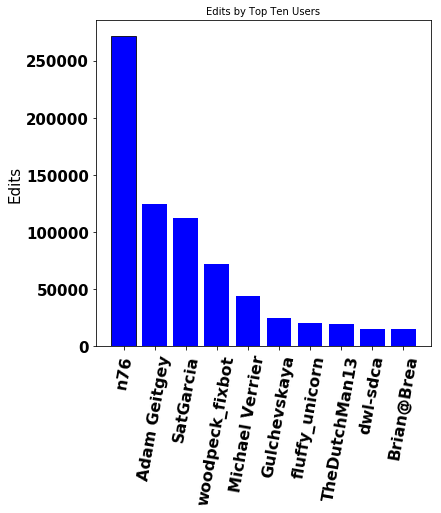

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

top10_df = pd.DataFrame(cur.execute(qtop10).fetchall())
top10_df.rename(columns={0: 'User', 1: 'Edits'}, inplace=True)
labels = list(top10_df['User'])

fig, ax = plt.subplots(figsize=(6,6))
ind = np.arange(10)
ax.bar(ind, top10_df['Edits'], width =0.8, color='blue', edgecolor='black', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 80, size = 16)
plt.title('Edits by Top Ten Users', size = 10); plt.ylabel('Edits', size = 15);
plt.show()

In [182]:
# all edits
cur.execute("SELECT COUNT (*) FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways)")
print (cur.fetchall())

[(1175157,)]


In [147]:
# share of top 10 users
(271594+124340+112135+72322+43928+25205+20077+19570+15614+15200)/1175157

0.6126713281714699

In [148]:
# share of 2075 - top 10 users

1-0.6127

0.3873

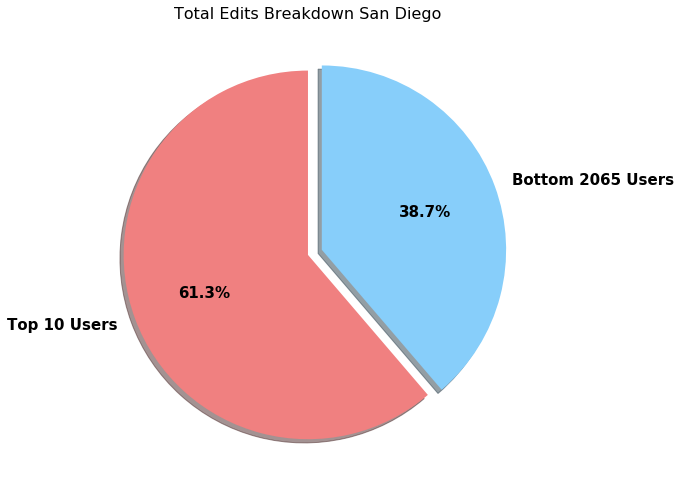

In [176]:
from pylab import *
figure(3, figsize=(8,8))
ax = axes([0.1, 0.1, 0.8, 0.8])
explode = (0.00, 0.08)
labels = ['Top 10 Users', 'Bottom 2065 Users']
colors = ['lightcoral', 'lightskyblue']
percents = ['61.27', '38.73']
pie(percents, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=90)
title('Total Edits Breakdown San Diego', size = 16);
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font);
plt.show()

In [132]:
# users with only 1 edit
cur.execute("SELECT COUNT(*) FROM (SELECT e.user, COUNT(*) as num FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e GROUP BY e.user HAVING num=1) u")
print (cur.fetchall())

[(254,)]


In [175]:
cur.execute("SELECT value, COUNT(*) as num FROM nodes_tags WHERE key='amenity' GROUP BY value ORDER BY num DESC LIMIT 10")
print (cur.fetchall())

[('place_of_worship', 794), ('restaurant', 542), ('fast_food', 475), ('bar', 268), ('school', 240), ('cafe', 205), ('bench', 125), ('fuel', 99), ('bank', 87), ('toilets', 77)]


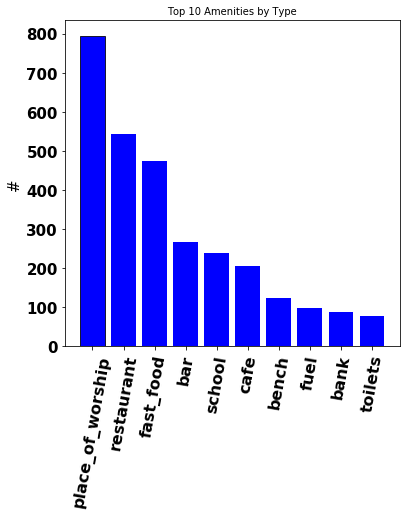

In [181]:
qtop10_amen = ("SELECT value, COUNT(*) as num FROM nodes_tags WHERE key='amenity' GROUP BY value ORDER BY num DESC LIMIT 10")

top10_amen_df = pd.DataFrame(cur.execute(qtop10_amen).fetchall())
top10_amen_df.rename(columns={0: 'Amenities', 1: '#'}, inplace=True)
labels = list(top10_amen_df['Amenities'])

fig, ax = plt.subplots(figsize=(6,6))
ind = np.arange(10)
ax.bar(ind, top10_amen_df['#'], width =0.8, color='blue', edgecolor='black', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 80, size = 16)
plt.title('Top 10 Amenities by Type', size = 10); plt.ylabel('#', size = 15);
plt.show()


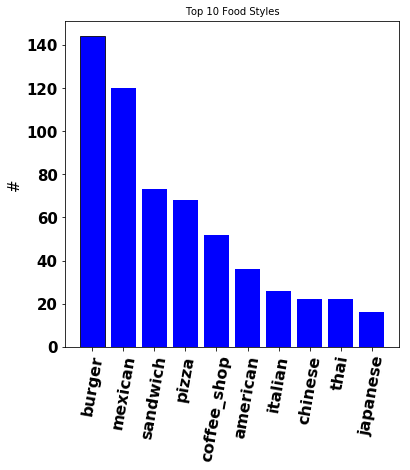

In [179]:
qtop10_food = ("SELECT value, COUNT(*) as num FROM nodes_tags WHERE key='cuisine' GROUP BY value ORDER BY num DESC LIMIT 10")

top10_food_df = pd.DataFrame(cur.execute(qtop10_food).fetchall())
top10_food_df.rename(columns={0: 'Cuisine Style', 1: '#'}, inplace=True)
labels = list(top10_food_df['Cuisine Style'])

fig, ax = plt.subplots(figsize=(6,6))
ind = np.arange(10)
ax.bar(ind, top10_food_df['#'], width =0.8, color='blue', edgecolor='black', linewidth=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation = 80, size = 16)
plt.title('Top 10 Food Styles', size = 10); plt.ylabel('#', size = 15);
plt.show()

In [143]:
cur.execute("SELECT value, COUNT(*) as num FROM nodes_tags WHERE key='cuisine' GROUP BY value ORDER BY num DESC LIMIT 10")
print (cur.fetchall())

[('burger', 144), ('mexican', 120), ('sandwich', 73), ('pizza', 68), ('coffee_shop', 52), ('american', 36), ('italian', 26), ('chinese', 22), ('thai', 22), ('japanese', 16)]


In [139]:
cur.execute("SELECT value, COUNT(*) as num FROM nodes_tags WHERE key='sport' GROUP BY value ORDER BY num DESC LIMIT 10")
print (cur.fetchall())

[('gymnastics', 14), ('swimming', 6), ('tennis', 2), ('baseball', 1), ('billiards', 1), ('boxing', 1), ('cliff_diving', 1), ('climbing', 1), ('fitness', 1), ('free_flying', 1)]
